In [1]:
import torch
import torch.backends.cudnn as cudnn
device = torch.cuda.set_device('cuda:1')
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
import numpy as np
from utils import *
from skimage.io import imread
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose
import cv2

In [2]:
import archs

In [3]:
model = archs.NestedUNet(1, 1, False)

In [4]:
model = model.cuda()

In [5]:
#Load save model
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [6]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [7]:
network_size = (256,256,1)

In [8]:
overlap = 128

In [121]:
image = np.asarray(imread('WPTest.PNG'))
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

max_dim = max(img.shape)
new_img = np.zeros((max_dim, max_dim))
new_img[0:img.shape[0], 0:img.shape[1]] = img
img = new_img

img = resize(img, (256, 256), preserve_range = True, anti_aliasing=False)

img = img.reshape((1,1,) + img.shape)

img = img.astype('float32')
                 
mean_ch = img.mean()
std_ch = img.std()
img = (img - mean_ch) / (std_ch)
print(img.min())
img = torch.from_numpy(img)
img = img.cuda()

-1.5251048


In [106]:
image_size = list(image.shape[0:2]) #Get image size and push to a list
tile_size = list(network_size[0:2]) #Get tile size as first two dimensions of network_size
        
corners = find_corners(image_size, tile_size, network_size, overlap)

img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mean_ch = img.mean()
std_ch = img.std()
img = (img - mean_ch) / (std_ch)
img = img.reshape(img.shape + (1,))

tilesArr = create_tiles(img, corners, network_size)
tilesArr = tilesArr.astype('float32')
tilesArr = tilesArr.transpose(0, 3, 1, 2)
tilesArr = torch.from_numpy(tilesArr)
tilesArr = tilesArr.cuda()

tensor(-1.5017, device='cuda:1')


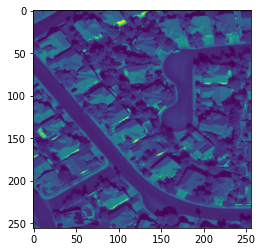

In [134]:
image2 = imread('/data/spacenet/bldg/AllTest/PAN-PNG/PAN_AOI_2_Vegas_img1008.png')
#img2 = np.array((image2[:,:,[4,2,1]]/(image2[:,:,[4,2,1]].max()+1e-10)), dtype=np.float32)
img2 = image2
#img2 = np.array(img2*255, dtype=np.uint8)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2 = resize(img2, (256, 256, 1))

plt.imshow(img2[:,:,0])

chan_mean = img2.mean()
chan_sd = img2.std()
img2 = (img2 - chan_mean) / chan_sd
 
img2 = img2.astype('float32')

img2 = img2.transpose(2, 0, 1)
img2 = img2.reshape(1, 1, 256, 256)
img2 = torch.from_numpy(img2)
img2 = img2.cuda()
print(img2.min())

In [135]:
with torch.no_grad():
    #output = model(tilesArr)
    output = model(img2)
    output = torch.sigmoid(output).cpu().numpy()

In [98]:
torch.cuda.empty_cache()

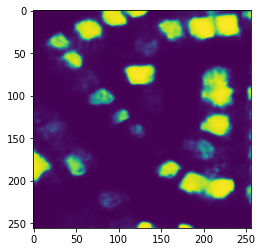

In [136]:
plt.imshow(output[0,0,:,:])

In [111]:
def assemble_pred(predArr, corners, image, network_size):
    pred_image = np.zeros((image.shape[0], image.shape[1]))
    pred_image[:,:] = np.nan #NaN so we only average the overlap
    corn_idx = 0
    for pred in predArr:
        cornerSet = corners[corn_idx]
        topY = cornerSet[0,0]
        topX = cornerSet[0,1]
        botY = cornerSet[1,0]
        botX = cornerSet[1,1]
        tile_shape = cornerSet[2]

        img_tile = pred_image[topY:botY, topX:botX] #Tile from our total prediction image
        
        flat_img_tile = np.ndarray.flatten(img_tile) 

        pred = pred[0, 0:tile_shape[0], 0:tile_shape[1]]
        
        flat_pred_tile = np.ndarray.flatten(pred)
    
        new_img_tile = list(map(lambda x, y: y if np.isnan(x) else (x+y)/2, flat_img_tile, flat_pred_tile)) #Average the predictions if x isn't NaN

        new_img_tile = np.asarray(new_img_tile).reshape(tile_shape)
        
        pred_image[topY:botY, topX:botX] = pred#new_img_tile
            
        corn_idx += 1  
    return pred_image      

In [112]:
final = assemble_pred(output, corners, image, network_size)

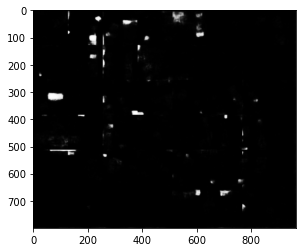

In [113]:
plt.imshow(final, cmap="gray")

In [ ]:
final2 = np.array(final*255, dtype="uint16")

In [ ]:
import cv2
ret2,th2 = cv2.threshold(final2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [ ]:
plt.imshow(th2, cmap = 'gray')

In [ ]:
plt.imshow(img[:,:,0], cmap="gray")